In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6037586808148023276
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3643801600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3361059356213376199
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
# MAX_VNUM = 20000
SEQUENCE_LENGTH = 300
EMBED_DIMENSION = 100
BATCH_SIZE = 64
K_FOLD = 5

In [4]:
column_names = ["lemmatized_clean_text", "labels"]
data = pd.read_csv("../Preprocessed_Dataset/ISOT_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[column_names]
train, test = train_test_split(data, test_size=0.2)

In [5]:
token = keras.preprocessing.text.Tokenizer()
token.fit_on_texts(data[column_names[0]])
vocab_size = len(token.word_index) + 2

In [6]:
embedding_vector = {}
f = open('../data/glove.6B.100d.txt')
for line in tqdm(f):
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embedding_vector[word] = coefs
embedding_matrix = np.zeros((vocab_size, EMBED_DIMENSION))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:11, 34622.65it/s]
100%|██████████| 131653/131653 [00:00<00:00, 1851268.63it/s]


### Model

In [7]:

def model_generator():
    model = keras.models.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIMENSION, 
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                        input_length=SEQUENCE_LENGTH, trainable = False))
    # model.add(layers.Permute((2, 1)))
    # model.add(layers.Conv1D(128, 5, activation='relu', name="Conv1D"))
    # model.add(layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(layers.LSTM(32, 
                        #   activation=None, 
                          name="LSTM"))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[
        "accuracy",
        tf.keras.metrics.Precision(), tf.keras.metrics.Recall()
    ])
    return model

In [8]:
train_x = token.texts_to_sequences(train[column_names[0]])
train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
train_y = train[column_names[1]]


In [9]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = K_FOLD)
history = {}
loss, accuracy, precision, recall, F1 = np.zeros(K_FOLD), np.zeros(K_FOLD), np.zeros(K_FOLD), np.zeros(K_FOLD), np.zeros(K_FOLD)
id = 0
epochs = 10
test_x = token.texts_to_sequences(test[column_names[0]])
test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
test_y = test[column_names[1]]
best_model = None
best_f1 = 0
best_id = 0
for train_index, val_index in kf.split(train_x, train_y):
    training_x, training_y = train_x[train_index], train_y.iloc[train_index]
    validation_x, validation_y = train_x[val_index], train_y.iloc[val_index]
    model = model_generator()
    history[id] = model.fit(x=training_x, y=training_y, validation_data=(validation_x, validation_y),
                                               epochs=epochs, batch_size=BATCH_SIZE)
    loss[id], accuracy[id], precision[id], recall[id] = model.evaluate(x=test_x, y=test_y)
    F1[id] = 2 * (precision[id] * recall[id]) / (precision[id] + recall[id])
    if F1[id] > best_f1:
        best_model = model
        best_f1 = F1[id]
        best_id = id
    id += 1
print("Best Model: Model_{}".format(best_id))


Epoch 1/10
449/449 [==============================] - 17s 24ms/step - loss: 0.6817 - accuracy: 0.5591 - precision: 0.5533 - recall: 0.3882 - val_loss: 0.6898 - val_accuracy: 0.5323 - val_precision: 0.5098 - val_recall: 0.8004
Epoch 2/10
449/449 [==============================] - 9s 20ms/step - loss: 0.6679 - accuracy: 0.5895 - precision: 0.5620 - recall: 0.6283 - val_loss: 0.6439 - val_accuracy: 0.6194 - val_precision: 0.5845 - val_recall: 0.7315
Epoch 3/10
449/449 [==============================] - 9s 19ms/step - loss: 0.6565 - accuracy: 0.5893 - precision: 0.5732 - recall: 0.5406 - val_loss: 0.6234 - val_accuracy: 0.6411 - val_precision: 0.6309 - val_recall: 0.6178
Epoch 4/10
449/449 [==============================] - 10s 22ms/step - loss: 0.6100 - accuracy: 0.6626 - precision: 0.6146 - recall: 0.7833 - val_loss: 0.5887 - val_accuracy: 0.6882 - val_precision: 0.6450 - val_recall: 0.7871
Epoch 5/10
449/449 [==============================] - 10s 23ms/step - loss: 0.5821 - accuracy: 0.6

In [10]:
from matplotlib import pyplot as plt

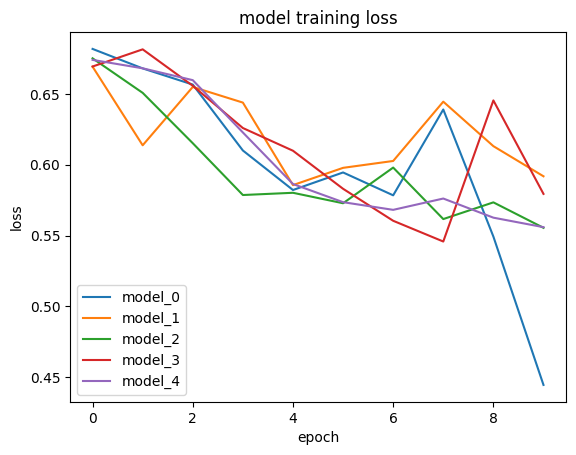

In [11]:
plt.title('model training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['loss'], label="model_{}".format(key))
plt.legend()

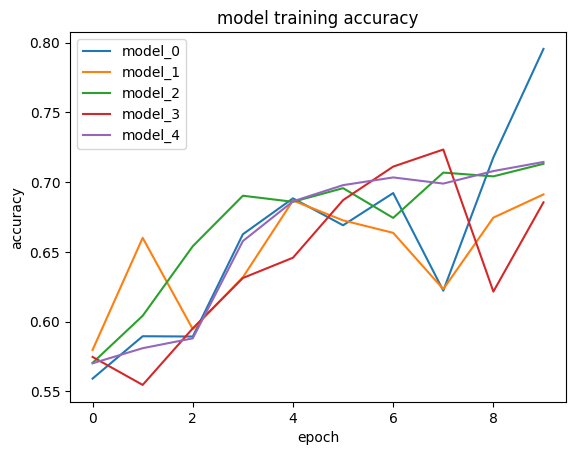

In [12]:
plt.title('model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['accuracy'], label="model_{}".format(key))
plt.legend()

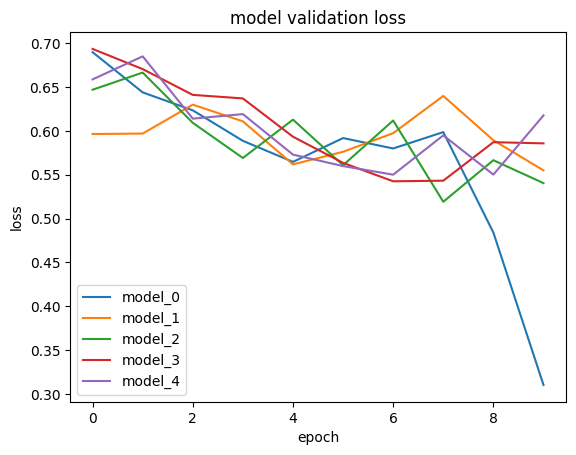

In [13]:
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['val_loss'], label="model_{}".format(key))
plt.legend()

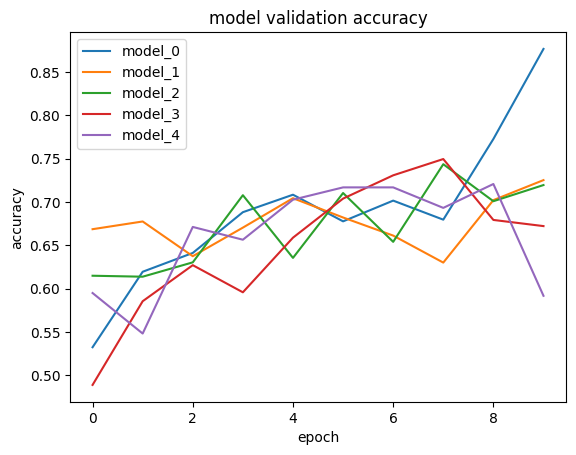

In [14]:
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['val_accuracy'], label="model_{}".format(key))
plt.legend()

In [15]:
print("Loss: {}, Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}".format(
    np.average(loss), np.average(accuracy), np.average(precision), np.average(recall), np.average(F1)
))

Loss: 0.518731701374054, Accuracy: 0.7208685874938965, Precision: 0.6872764587402344, Recall: 0.7699318766593933, F1 Score: 0.7009278361148866


In [16]:
best_model.save("RNN_ISOT")

INFO:tensorflow:Assets written to: RNN_ISOT\assets


INFO:tensorflow:Assets written to: RNN_ISOT\assets


### Generalization

In [17]:
fakes_column_names = ["lemmatized_clean_final_article", "labels"]
fakes_data = pd.read_csv("../Preprocessed_Dataset/Fakes_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[fakes_column_names]
fnc_column_names = ["lemmatized_clean_final_article", "labels"]
fnc_data = pd.read_csv("../Preprocessed_Dataset/fnc-1_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[fnc_column_names]

In [18]:
fakes_x = token.texts_to_sequences(fakes_data[fakes_column_names[0]])
fakes_x = keras.preprocessing.sequence.pad_sequences(fakes_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
fakes_y = fakes_data[fakes_column_names[1]]

fakes_loss, fakes_accuracy, fakes_precision, fakes_recall = best_model.evaluate(x=fakes_x, y=fakes_y)
fakes_F1 = 2 * (fakes_precision * fakes_recall) / (fakes_precision + fakes_recall)
print("FAKES Loss: {}, FAKES Accuracy: {}, FAKES Precision: {}, FAKES Recall: {}, FAKES F1: {}".format(fakes_loss, fakes_accuracy, fakes_precision, fakes_recall, fakes_F1))

26/26 [==============================] - 1s 20ms/step - loss: 1.2194 - accuracy: 0.5100 - precision: 0.5842 - recall: 0.2606
FAKES Loss: 1.2194442749023438, FAKES Accuracy: 0.5099502205848694, FAKES Precision: 0.5842105150222778, FAKES Recall: 0.26056337356567383, FAKES F1: 0.360389601816856


In [19]:
fnc_x = token.texts_to_sequences(fnc_data[fnc_column_names[0]])
fnc_x = keras.preprocessing.sequence.pad_sequences(fnc_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
fnc_y = fnc_data[fnc_column_names[1]]

fnc_loss, fnc_accuracy, fnc_precision, fnc_recall = best_model.evaluate(x=fnc_x, y=fnc_y)
fnc_F1 = 2 * (fnc_precision * fnc_recall) / (fnc_precision + fnc_recall)
print("FNC Loss: {}, FNC Accuracy: {}, FNC Precision: {}, FNC Recall: {}, FNC F1: {}".format(fnc_loss, fnc_accuracy, fnc_precision, fnc_recall, fnc_F1))

142/142 [==============================] - 1s 9ms/step - loss: 1.9695 - accuracy: 0.3395 - precision: 0.8002 - recall: 0.2515
FNC Loss: 1.9694687128067017, FNC Accuracy: 0.3395307660102844, FNC Precision: 0.8001729846000671, FNC Recall: 0.2514953911304474, FNC F1: 0.3827058460215184
